In [1]:
!pip3 install torch torchvision

In [0]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #cuda tensor type using gpu for computation

In [4]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))]) 
#Compose - chain together transofrmaton, convert numpy array from 0 to 255, into float tensor from 0 to 1
#encoded in tensor shape which characterizes image channel height and weight
#mean value and standard deviation - creates range from -1 to 1
#normalization reduce skewness and disttion within our data ensuring effective learning process

training_dataset = datasets.MNIST(root ='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root ='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

#suffle ensuring the training data cahgnes every iteration so it grad doesnt get stuck in local minimum

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 19695185.01it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 309045.34it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5608628.98it/s]                           
8192it [00:00, 128530.26it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() #detach to call numpy single color channel with height 28*28 pixels
  image = image.transpose(1,2,0) #swap axis 0 to axis 1, axis 1 to axis 2, and 0 in the end
  image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1) 
  return image

Training loader is what we do to specify training batches. 

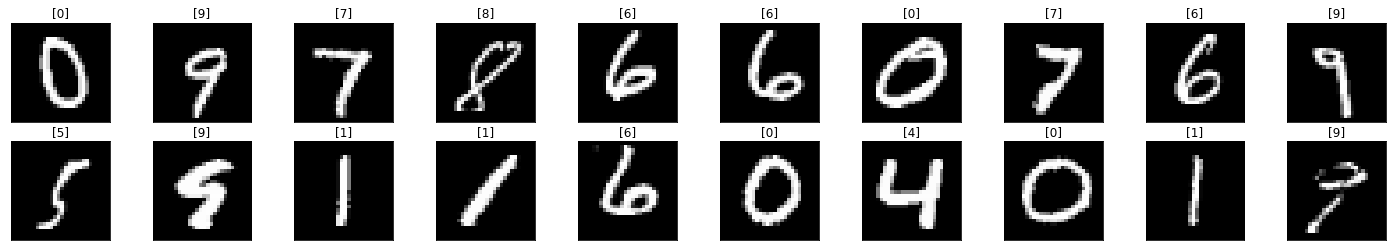

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1) #dont need large stride length because small images
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500) #50 output channels, each one by a 4 by 4 image
    self.dropout1 = nn.Dropout(0.5) #recommended rate to reduce overffiting
    self.fc2 = nn.Linear(500,10) 
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x= F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x= F.max_pool2d(x, 2, 2)
    x = x.view(-1,4*4*50) #put droupout layer between high parameters layer
    x = F.relu(self.fc1(x))
    self.dropout1(x)
    x = self.fc2(x) #no activation function
    return x

The Dropout layer this layer essentially functions by randomly setting a fraction rate of input units to 0 and each update during training which helps prevent over fitting the process can be seen within this image The image shows a standard neural network and it shows the same network after dropout is applied you can see that some nodes have been turned off and are no longer communicating information along the network. As mentioned earlier the dropout function randomly select a predefined fraction of nodes to be turned off what this means is that every time the network updates parameters during the training process it selects a random nodes that it is going to turn up.So while our figures show specific nodes that have been turned off it's important to note that a different set of nodes are turned off with each updates.This process works to prevent overfishing because it forces the neural network to use various combinations of nodes to classify the same data as with each updates a random set of nodes survived the drop up process. Each node is forced to learn the data set in a more independent way. Were they unique in neural arrangement each time. This causes the neural network in general to become more versatile and allows the weights to be more uniformly distributed along the network. No one this network is used on new data.

Drop out is not used and all the neural nodes are used to classify the new data.

One drop out is no longer used.

The nodes can combine all their independent learning to form a more effective neural network.

This results in a network that has reduced generalized error and demonstrates less over fitting when

it is exposed to new data the good albeit simplified example of this phenomenon is to imagine the following

situation.

In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
for i in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs,labels in training_loader:
    inputs = inputs.to(device) #every input goes in device
    labels = labels.to(device)
    
    #no need to flatten image
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _,pred = torch.max(outputs,1)
    running_corrects += torch.sum(pred == labels.data)
    running_loss += loss.item()
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs,val_labels)
        
        _,val_pred = torch.max(val_outputs,1)
        val_running_corrects += torch.sum(val_pred == val_labels.data)
        val_running_loss += val_loss.item()
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch:', (i+1))
    print('Training Loss:{:.4f}, {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('Validation Loss:{:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
    

epoch: 1
Training Loss:0.5025, 88.2367
Validation Loss:0.1521, validation acc 95.6600
epoch: 2
Training Loss:0.1224, 96.4083
Validation Loss:0.0821, validation acc 97.5400
epoch: 3
Training Loss:0.0806, 97.5667
Validation Loss:0.0601, validation acc 98.1500
epoch: 4
Training Loss:0.0625, 98.1400
Validation Loss:0.0494, validation acc 98.3200
epoch: 5
Training Loss:0.0522, 98.4067
Validation Loss:0.0438, validation acc 98.6400
epoch: 6
Training Loss:0.0454, 98.6317
Validation Loss:0.0456, validation acc 98.4800
epoch: 7
Training Loss:0.0397, 98.7950
Validation Loss:0.0334, validation acc 98.9100
epoch: 8
Training Loss:0.0349, 98.9583
Validation Loss:0.0298, validation acc 99.0000
epoch: 9
Training Loss:0.0313, 99.0817
Validation Loss:0.0297, validation acc 98.9600
epoch: 10
Training Loss:0.0280, 99.1383
Validation Loss:0.0290, validation acc 99.1000
epoch: 11
Training Loss:0.0252, 99.2350
Validation Loss:0.0337, validation acc 98.9200
epoch: 12
Training Loss:0.0226, 99.3000
Validation L

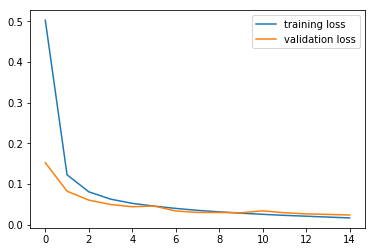

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

Loss fluctuates as epoch progress
Too loss of learning rate cause dracistic updates which flip flops

If learning rate slow or loss function gets stuck at minimum. Higher learning rate inherit divergent behaviors that will alors parameters to escape the local minima

Use of low lr of a loss that stop decreasing at high value



---



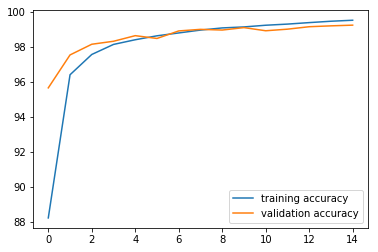

In [12]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

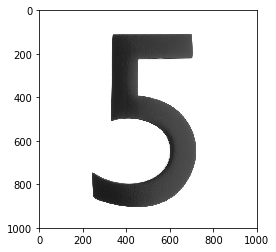

In [13]:
import requests
import PIL.ImageOps
from PIL import Image
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)


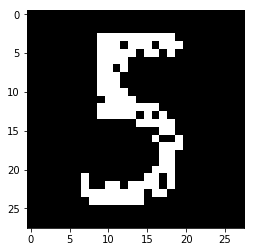

In [14]:
img = PIL.ImageOps.invert(img)
img = img.convert('1') #1 converts into bilevel image
img = transform(img)
plt.imshow(im_convert(img))

In [15]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0) #new tensor with and what this will return is a new tensor with a dimension of size 1 inserted at the specified position zero and it does
#that twice and that is how we will account for the extra dimensionality that's needed to satisfy the
#following error.
output = model(image)
_,pred = torch.max(output,1)
print(pred.item())

5


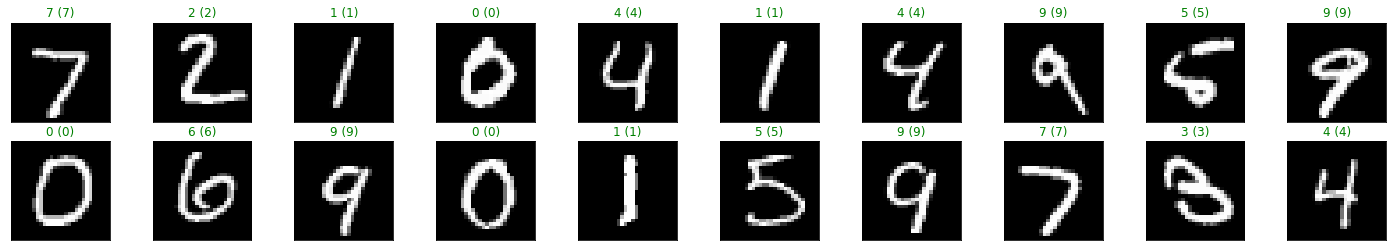

In [22]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx])) #cant convert tensor cudo to np
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),color =("green" if preds[idx] == labels[idx] else "red"))